# Machine Learning

In [55]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors, linear_model, ensemble
import itertools
import warnings; warnings.simplefilter('ignore')
import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb
!{sys.executable} -m pip install lightgbm
import lightgbm as lgb
%matplotlib inline

final = pd.read_csv("~/data301/share/Brooke_Michal/final_data.csv")
final.head()

,Country,Country Code,1990_P,1997_P,1998_P,1999_P,2000_P,2001_P,2002_P,2003_P,...,2016_M,latest_value_M,Government Type,Religion,Pop. Density (per sq. mi.),Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Birthrate,Deathrate
0,Afghanistan,AFG,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Republic,Muslims,48.0,163.07,700.0,36.0,46.60,20.34
1,Angola,AGO,14.5,9.5,15.5,15.5,15.5,15.5,15.5,15.5,...,NaN,NaN,Republic,Christians,9.7,191.19,1900.0,42.0,45.11,24.20
2,Albania,ALB,28.8,NaN,NaN,5.2,5.2,5.7,5.7,5.7,...,NaN,22.47,Republic,Muslims,124.6,21.52,4500.0,86.5,15.11,5.22
3,Andorra,AND,NaN,7.1,7.1,7.1,7.1,14.3,14.3,14.3,...,NaN,NaN,Constitutional Monarchy,Christians,152.1,4.05,19000.0,100.0,8.71,6.25
4,United Arab Emirates,ARE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,Absolute Monarchy,Muslims,31.4,14.51,23200.0,77.9,18.96,4.40


**Predicting Proportion of Women in Parliament:** 

In [56]:
features_options = ['Government Type','Religion', 
        'Infant mortality (per 1000 births)', 'Literacy (%)',
        'Birthrate', 'Deathrate']

In [57]:
final_clean = final[features_options].dropna()

In [58]:
# creating a power set of all possible feature combinations
features = []
for i in range(1, len(features_options)+1):
    ls = [list(x) for x in itertools.combinations(features_options, i)]
    features.extend(ls)

In [59]:
y = final["2018_P"].loc[final_clean.index]
vec = DictVectorizer(sparse=False)
scaler = preprocessing.StandardScaler()

In [60]:
# calcuate the error for all possible feature combinations
def get_best_features(model):
    """ returns a touple with the best feautres 
    and the smallest cross validation error of those features"""
    
    errors = {}
    pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])

    for i in range(0, len(features)):
        X_dict = final_clean[features[i]].to_dict(orient="records")
        scores = cross_val_score(pipeline, X_dict, y, 
                         cv=5, scoring="neg_mean_squared_error")
        errors.update({str(features[i]):np.sqrt(np.mean(-scores))})
        
    return errors

**K Nearest Neighbors Regressor:**

In [61]:
errors_knn = get_best_features(neighbors.KNeighborsRegressor(n_neighbors=10))
best_features_knn = eval(min(errors_knn, key=errors_knn.get))
(best_features_knn, errors_knn[str(best_features_knn)])

(['Religion',
  'Infant mortality (per 1000 births)',
  'Literacy (%)',
  'Birthrate'],
 11.100913305601814)

**Linear Regression:**

In [62]:
errors_lr = get_best_features(linear_model.LinearRegression())
best_features_lr = eval(min(errors_lr, key=errors_lr.get))
(best_features_lr, errors_lr[str(best_features_lr)])

(['Religion', 'Infant mortality (per 1000 births)', 'Birthrate'],
 11.332476133079059)

**Bagging Regressor:**

In [63]:
errors_bagging = get_best_features(ensemble.BaggingRegressor())
best_features_bagging = eval(min(errors_bagging, key=errors_bagging.get))
(best_features_bagging, errors_bagging[str(best_features_bagging)])

(['Government Type', 'Religion'], 11.377689091645527)

**XGBoost Regressor:**

In [64]:
errors_xgb = get_best_features(xgb.XGBRegressor())
best_features_xgb = eval(min(errors_xgb, key=errors_xgb.get))
(best_features_xgb, errors_xgb[str(best_features_xgb)])

(['Religion'], 11.355423511376603)

**LightGBM Regressor:**

In [65]:
errors_lgb = get_best_features(lgb.LGBMRegressor())
best_features_lgb = eval(min(errors_lgb, key=errors_lgb.get))
(best_features_lgb, errors_lgb[str(best_features_lgb)])

(['Government Type', 'Religion'], 11.272798882994932)

In [66]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class RegressionEnsembler(BaseEstimator, RegressorMixin):
    """Creates an ensemble model out of a collection of individual estimators
    
    Args:
      estimators: A list containing the individual estimators.
    """
    
    def __init__(self, estimators):
        self.estimators = estimators
        
    def fit(self, X, y):
        # check that X and y have the correct shape
        X, y = check_X_y(X, y)
        
        # store the training features and the labels
        self.X_ = X
        self.y_ = y
        
        # call the fit method of each of the estimators
        for estimator in self.estimators:
            estimator.fit(X, y)
        return self
    
    def predict(self, X):
        # check that fit has been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # check that X has the right form
        X = check_array(X)
        
        # calculate predictions from the estimators
        predictions = []
        for estimator in self.estimators:
            predictions.append(estimator.predict(X))
        Y_ = np.column_stack(predictions)
        
        # return predictions
        return Y_.mean(axis=1)

The best models from above are KNeighborsRegressor and LGBMRegressor, so we will explore their combination.

In [67]:
errors_ensembler = get_best_features(
    RegressionEnsembler([lgb.LGBMRegressor(), 
                         neighbors.KNeighborsRegressor(n_neighbors=10)]))
best_features_ensembler = eval(min(errors_ensembler, key=errors_ensembler.get))
(best_features_ensembler, errors_ensembler[str(best_features_ensembler)])

(['Religion',
  'Infant mortality (per 1000 births)',
  'Literacy (%)',
  'Birthrate'],
 11.18278268339431)

K Nearest Neighbors alone returned the lowest RMSE overall.
Based upon the rmse of a model, we found that religion, infant mortality, literacy, and the birthrate of a country are the best predictors of the proportion of women will be in national parliament. It's also interesting to note that religion was one of the optimal features in every model we tested. 

**Scalers and Distance Metrics:**
Now we will explore what combination of distance metric and scalers that will produce the lowest error with our chosen features and model.

In [68]:
distance_metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]
scalers = [preprocessing.StandardScaler(), preprocessing.Normalizer(), 
           preprocessing.MinMaxScaler(), preprocessing.RobustScaler(),
           preprocessing.QuantileTransformer()]

In [69]:
errors = {}
for i in range(0,len(distance_metrics)):
    for j in range(0, len(scalers)):
        X_dict = final_clean[best_features_knn].to_dict(orient="records")
        scaler = scalers[j]
        model = KNeighborsRegressor(n_neighbors=10, metric = distance_metrics[i])
        pipeline = Pipeline([("vectorizer", vec),
                             ("scaler", scaler), ("fit", model)])
        scores = cross_val_score(pipeline, X_dict, y, cv=5, 
                             scoring="neg_mean_squared_error")
        errors.update(
            {(distance_metrics[i], scalers[j]):np.sqrt(np.mean(-scores))})

In [70]:
# find the smallest error based on distance metric and scaler
min(errors, key=errors.get)

('euclidean', StandardScaler(copy=True, with_mean=True, with_std=True))

In [71]:
X_train_dict = final_clean[best_features_knn].to_dict(orient="records")
scaler = preprocessing.StandardScaler()

In [72]:
def get_val_error(X_train_dict, y, k):    
    model = KNeighborsRegressor(n_neighbors=k, metric = 'euclidean')
    pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])
    scores = cross_val_score(pipeline, X_train_dict, y, cv=10, 
                         scoring="neg_mean_squared_error")
    rmse = np.sqrt(np.mean(-scores))
    return rmse

In [73]:
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

In [74]:
def get_training_error(X_train_sc, y_train, k):
    model = KNeighborsRegressor(n_neighbors=k, metric = "manhattan")
    model.fit(X_train_sc, y_train)
    y_train_pred = model.predict(X_train_sc)
    mse = ((y_train - y_train_pred) ** 2).mean()
    rmse = np.sqrt(mse)
    return rmse

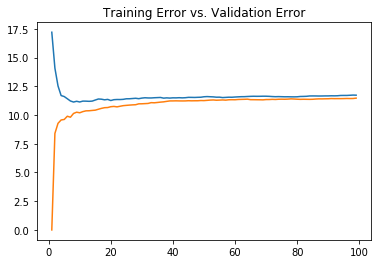

In [75]:
# plot training and validation error
k = pd.Series(range(1,100))
k.index = range(1,100)
val_error = k.apply(lambda k: get_val_error(X_train_dict, y, k))
val_error.plot.line()
training_error = k.apply(lambda k: get_training_error(X_train_sc, y, k))
training_error.plot.line(title = "Training Error vs. Validation Error")

In [76]:
# best K will have smallest error
val_error.idxmin()

8

Let's see what countries have missing values for proportion of women in parliament in 2018 so we can predict the unknowns using our chosen model. 

In [77]:
unknown = final[final["2018_P"].isna()]
unknown["Literacy (%)"] = 96
unknown

,Country,Country Code,1990_P,1997_P,1998_P,1999_P,2000_P,2001_P,2002_P,2003_P,...,2016_M,latest_value_M,Government Type,Religion,Pop. Density (per sq. mi.),Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Birthrate,Deathrate
135,Palestine,PSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,15.42,Republic,Muslims,4388.7,42.55,1400.0,96,71.12,7.72


Source for litreracy percentage above: https://fred.stlouisfed.org/series/SEADTLITRZSPSE

In [78]:
X_train_dict = final_clean[best_features_knn].to_dict(orient="records")

scaler = preprocessing.StandardScaler()
model = KNeighborsRegressor(n_neighbors=8, metric = 'euclidean')

X_new_dict = unknown[best_features_knn].to_dict(orient="records")
vec.fit(X_train_dict)
X_train = vec.transform(X_train_dict)
X_new = vec.transform(X_new_dict)

scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_new_sc = scaler.transform(X_new)

model.fit(X_train_sc, y)

unknown["2018_P"] = model.predict(X_new_sc)

In [79]:
unknown["2018_P"]

135    14.2875
Name: 2018_P, dtype: float64

The model wasn't too far off! Our model predicted that 14.2875% of the national parliemnt of Palestinian territories is composed of women and the actual to percent of women in the national parliament is 12.9% in Palestine. 
Source: http://palestine.unwomen.org/en/what-we-do/leadership-and-political-participation/facts-and-figures

# Exploring Proportion of Women in Parliament Statistic Further

Can we predict a country's government type by the proportion of women in their national parliament?

In [80]:
final[final["Government Type"].isna()]

,Country,Country Code,1990_P,1997_P,1998_P,1999_P,2000_P,2001_P,2002_P,2003_P,...,2016_M,latest_value_M,Government Type,Religion,Pop. Density (per sq. mi.),Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Birthrate,Deathrate
92,Libya,LBY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Muslims,3.4,24.6,6400.0,82.6,26.49,3.48


Since Libya's government type is unknown, we will use the proportion of women in their national parliament over the past 10 years to predict Libya's government type.

In [81]:
features = ['2008_P', '2009_P', '2010_P', '2011_P', '2012_P', '2013_P',
       '2014_P', '2015_P', '2016_P', '2017_P', '2018_P']

features.append("Government Type")
final_clean = final[features].dropna()
y_train = final_clean["Government Type"]
features.remove("Government Type")
X_train = final_clean[features]

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train_sc, y_train)

#2011_P is nan, so filled it with 2010_P value
x_new = final[final["Country"] == "Libya"][features].fillna(7.7)
x_new_sc = scaler.transform(x_new)

model.predict(x_new_sc)

array(['Republic'], dtype=object)

Libya currently has a transitional government following a civil war. It has bounced between a presidential republic and a constitutional republic, so this is a reasonable prediction. This further emphasizes how country to country variation affects the statistics we're investigating. 

How did the classification model do overall? 

In [82]:
(cross_val_score(model,
                   X_train, y_train, 
                    cv=5, scoring= "accuracy").mean(),
cross_val_score(model,
                   X_train, y_train == "Republic", 
                    cv=5, scoring= "precision").mean(),
cross_val_score(model,
                   X_train, y_train == "Republic", 
                    cv=5, scoring= "recall").mean())

(0.689630412282215, 0.75362243120863803, 0.89433333333333331)

An accuracy score of 0.689 means that our model predictded the correct form of government for a country 68.9% of the time. The precision score of 0.754 means that 75.4% of the countries that were predicted to be a republic, actually were a republic. Finally, a recall score of 0.894 means that 89.4% of the coutnries that have a republic form of government, were predicted to have a republic. 

**Predicting women in senior and middle managment positions from the amount of women in national parliaments:**

Note that we only have 70 observations (after accounting for missing values) to train this model, so the small sample size may affect the results.

In [83]:
known_manag = final[~final["latest_value_M"].isna()]
unknown_manag = final[final["latest_value_M"].isna()]

In [84]:
features = ['2008_P', '2009_P', '2010_P', '2011_P', '2012_P', '2013_P',
       '2014_P', '2015_P', '2016_P', '2017_P', '2018_P']

final_clean = known_manag[features].dropna()
y_train = known_manag["latest_value_M"].loc[final_clean.index]
X_train = final_clean[features]

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

model = KNeighborsRegressor(n_neighbors=30, metric = "manhattan")
model.fit(X_train_sc, y_train)

x_new = unknown_manag[features].dropna()
x_new_sc = scaler.transform(x_new)

unknown_manag["latest_value_M"].loc[x_new.index] = model.predict(x_new_sc)

In [85]:
unknown_manag.head()

,Country,Country Code,1990_P,1997_P,1998_P,1999_P,2000_P,2001_P,2002_P,2003_P,...,2016_M,latest_value_M,Government Type,Religion,Pop. Density (per sq. mi.),Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Birthrate,Deathrate
0,Afghanistan,AFG,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,32.168667,Republic,Muslims,48.0,163.07,700.0,36.0,46.60,20.34
1,Angola,AGO,14.5,9.5,15.5,15.5,15.5,15.5,15.5,15.5,...,NaN,32.326333,Republic,Christians,9.7,191.19,1900.0,42.0,45.11,24.20
3,Andorra,AND,NaN,7.1,7.1,7.1,7.1,14.3,14.3,14.3,...,NaN,32.326333,Constitutional Monarchy,Christians,152.1,4.05,19000.0,100.0,8.71,6.25
4,United Arab Emirates,ARE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,31.739333,Absolute Monarchy,Muslims,31.4,14.51,23200.0,77.9,18.96,4.40
6,Armenia,ARM,35.6,6.3,6.3,3.1,3.1,3.1,3.1,4.6,...,NaN,29.779333,Republic,Christians,99.9,23.28,3500.0,98.6,12.07,8.23


In [86]:
(unknown_manag["latest_value_M"].min(), unknown_manag["latest_value_M"].max())

(28.761333333333333, 33.120333333333335)

As expected, our predictions were affected by the small sample size. This resulted in a narrow range of predictions which is not realistic. 

**How well can we predict a country's literacy percentage using the proportion of women in parliament?**

In [87]:
features = ['2008_P', '2009_P', '2010_P', '2011_P', '2012_P', '2013_P',
       '2014_P', '2015_P', '2016_P', '2017_P', '2018_P']

label_features = features
label_features.append("Literacy (%)")

final_clean = final[label_features].dropna()
y_train = final_clean["Literacy (%)"]
X_train = final_clean[features]

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train_sc, y_train)

pipeline = Pipeline([("scaler", scaler), ("fit", model)])
scores = cross_val_score(pipeline, X_train, y_train, cv=10, 
                         scoring="neg_mean_squared_error")
rmse = np.sqrt(np.mean(-scores))
rmse

5.2960611236961679

Above we caluclated the validation rmse for predicting the literacy rate of a country based upon the proportion of women in that country's government. The rmse was a value of 5.29. This means that on average, the difference between the actual literacy rate of the country and the predicted literacy rate was 5.29%. 